In [1]:
import sys
sys.path.append('../../../')

In [2]:
from win10toast import ToastNotifier
toast = ToastNotifier()

In [3]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train_reg import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error, mean_absolute_error

Using backend: pytorch


In [4]:
def pretty(ld, indent=0):
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [41]:
do_train = False

seed = 4444
set_seed(seed)

metric_filter_1 = 'test_rmse_perc'
metric_filter_2 = 'val_rmse_perc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [6]:
sets_lengths = (0.5, 0.25, 0.25)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = 1

## Baseline

### FNN

In [7]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[100], [100] * 2, [100] * 3, [200], [200]*2,[200]*3,[500],[500]*2,[500]*3],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

In [8]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=200,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=False,
            loss_type='mse',
            scheduler_patience=20,
        )

100%|██████████| 54/54 [17:29<00:00, 19.43s/it]


#### Results

In [9]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 1134/1134 [01:33<00:00, 12.10it/s]


In [42]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [100, 100, 100],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 20,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.52224106,
 'train_acc': 0.5664820075035095,
 'val_acc': 0.5955678820610046,
 'epoch': 70,
 'model_class': 'fnn',
 'path_name': '4_[100_100_100]_4_ReLU()_gn_0.0_0.1_adamw_max_val_mcc_False_mse_20_False_0_70',
 'train_rmse': 0.8093977104857736,
 'val_rmse': 0.871207650381413,
 'test_rmse': 0.902443589446434,
 'train_rmse_perc': 0.1884183,
 'val_rmse_perc': 0.21049692,
 'test_rmse_perc': 0.21672378,
 'train_mcc': 0.42365982598505986,
 'val_mcc': 0.4587277287084364,
 'test_mcc': 0.4701168731181468,
 'test_acc': 0.6011080145835876}

In [46]:
all = res_edges[2]
# ascending order
# sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [200, 200, 200],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 20,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.45421863,
 'train_acc': 0.5484764575958252,
 'val_acc': 0.5290858745574951,
 'epoch': 150,
 'model_class': 'fnn',
 'path_name': '4_[200_200_200]_4_ReLU()_bn_0.0_0.1_adamw_max_val_mcc_False_mse_20_False_0_150',
 'train_rmse': 0.7770959505386,
 'val_rmse': 0.8453883370636321,
 'test_rmse': 0.8791206888678982,
 'train_rmse_perc': 0.17907526,
 'val_rmse_perc': 0.20652014,
 'test_rmse_perc': 0.21113515,
 'train_mcc': 0.3987461700751778,
 'val_mcc': 0.374427161303355,
 'test_mcc': 0.35828216171561034,
 'test_acc': 0.5180055499076843}

In [48]:
all = res_edges[2]
# ascending order
# sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [200, 200, 200],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': False,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 20,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 0.45421863,
 'train_acc': 0.5484764575958252,
 'val_acc': 0.5290858745574951,
 'epoch': 150,
 'model_class': 'fnn',
 'path_name': '4_[200_200_200]_4_ReLU()_bn_0.0_0.1_adamw_max_val_mcc_False_mse_20_False_0_150',
 'train_rmse': 0.7770959505386,
 'val_rmse': 0.8453883370636321,
 'test_rmse': 0.8791206888678982,
 'train_rmse_perc': 0.17907526,
 'val_rmse_perc': 0.20652014,
 'test_rmse_perc': 0.21113515,
 'train_mcc': 0.3987461700751778,
 'val_mcc': 0.374427161303355,
 'test_mcc': 0.35828216171561034,
 'test_acc': 0.5180055499076843}

In [45]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1134/1134 [00:00<00:00, 23205.06it/s]


### GCN

In [ ]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[10] * 3],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0,],
#     use_edge_weight=[True, ],
#     drop_edges=[0,0.2],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [ ]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

#### Results

In [ ]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

In [ ]:
res_edges = res_edges_gcn
res_edges[0]

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

In [ ]:
pretty([all[k]['dict'] for k in sort_idx])

### GraphSAGE

In [14]:
save_model = f'{save_path}_sage'
log_dir = f'{log_path}_sage'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['right', 'none'],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0.2, 0],
#     # other
#     lr=[1e-2],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0,0.2],
# )
# list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[500]*2], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['none'],
    norm_nodes = ['gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0, 0.2],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0, 0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [15]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=2000,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=50,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            scheduler_patience=300,
        )

100%|██████████| 4/4 [1:47:06<00:00, 1606.63s/it]


#### Results

In [16]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

toast.show_toast("Done")

100%|██████████| 197/197 [01:50<00:00,  1.78it/s]


True

In [53]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 300,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.22543687,
 'train_acc': 0.8157894611358643,
 'val_acc': 0.7119113802909851,
 'epoch': 1250,
 'model_class': 'sage',
 'path_name': '4_[500_500]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_300_True_0.2_1250',
 'train_rmse': 0.4794965041654894,
 'val_rmse': 0.713929471907923,
 'test_rmse': 0.7330730672202168,
 'train_rmse_perc': 0.1288818,
 'val_rmse_perc': 0.19355673,
 'test_rmse_perc': 0.18671641,
 'train_mcc': 0.7552885327459816,
 'val_mcc': 0.6138580822578542,
 'test_mcc': 0.5738211962655886,
 'test_acc': 0.678670346736908}

In [54]:
all = res_edges[2]
# ascending order
# sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 300,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.22543687,
 'train_acc': 0.8157894611358643,
 'val_acc': 0.7119113802909851,
 'epoch': 1250,
 'model_class': 'sage',
 'path_name': '4_[500_500]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_300_True_0.2_1250',
 'train_rmse': 0.4794965041654894,
 'val_rmse': 0.713929471907923,
 'test_rmse': 0.7330730672202168,
 'train_rmse_perc': 0.1288818,
 'val_rmse_perc': 0.19355673,
 'test_rmse_perc': 0.18671641,
 'train_mcc': 0.7552885327459816,
 'val_mcc': 0.6138580822578542,
 'test_mcc': 0.5738211962655886,
 'test_acc': 0.678670346736908}

In [55]:
all = res_edges[2]
# ascending order
# sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 300,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.22543687,
 'train_acc': 0.8157894611358643,
 'val_acc': 0.7119113802909851,
 'epoch': 1250,
 'model_class': 'sage',
 'path_name': '4_[500_500]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_300_True_0.2_1250',
 'train_rmse': 0.4794965041654894,
 'val_rmse': 0.713929471907923,
 'test_rmse': 0.7330730672202168,
 'train_rmse_perc': 0.1288818,
 'val_rmse_perc': 0.19355673,
 'test_rmse_perc': 0.18671641,
 'train_mcc': 0.7552885327459816,
 'val_mcc': 0.6138580822578542,
 'test_mcc': 0.5738211962655886,
 'test_acc': 0.678670346736908}

In [56]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 197/197 [00:00<00:00, 6584.46it/s]


#### cm

In [57]:
cm = all[sort_idx[0]]['test_cm'][0]

In [58]:
(cm.labels==0).sum()

tensor(87)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

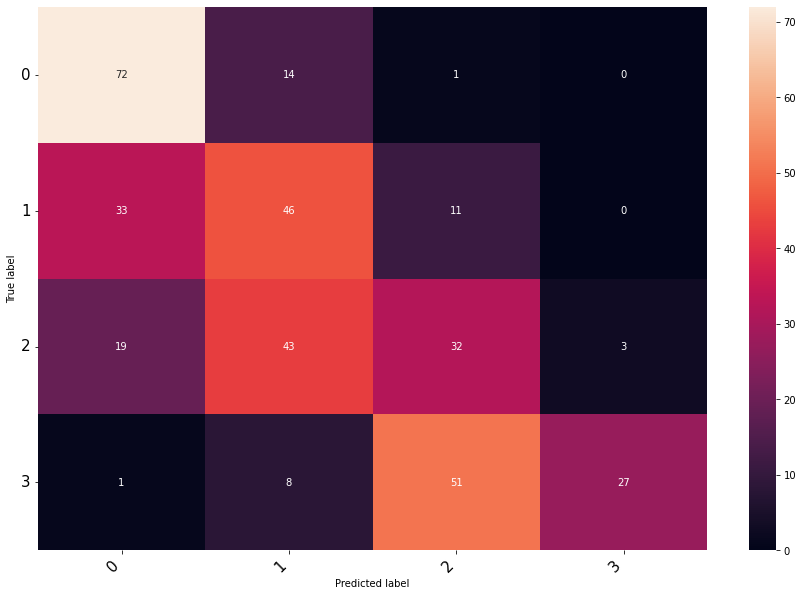

In [71]:
cm.visualize()

In [60]:
cm.class_accuracy

tensor([0.7701, 0.5333, 0.5155, 0.9195])

In [61]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.17444374, 0.2078008, 0.22503935, 0.11444203]

In [62]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.103589155, 0.15490447, 0.16820103, 0.08990897]

#### GraphSAGE Base_n

In [27]:
save_model = f'{save_path}_sage_base'
log_dir = f'{log_path}_sage_base'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['right', 'none'],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0.2, 0],
#     # other
#     lr=[1e-2],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0,0.2],
# )
# list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[500]*2], 
    out_features = [out_feats],
    aggregator_type = ['lstm'],
    norm_edges = ['none'],
    norm_nodes = ['gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0, 0.2],
    # other
    lr=[1e-2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0, 0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [28]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=2000,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=50,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
            scheduler_patience=300,
            base_n=True,
        )

100%|██████████| 4/4 [1:45:48<00:00, 1587.00s/it]


##### Results

In [29]:
res_edges_sage_base = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
    base_n=True,
)

toast.show_toast("Done")

100%|██████████| 164/164 [01:20<00:00,  2.03it/s]


True

In [63]:
res_edges = res_edges_sage_base
res_edges[0]

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 300,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.19805254,
 'train_acc': 0.5512465238571167,
 'val_acc': 0.5263158082962036,
 'epoch': 1950,
 'model_class': 'sage',
 'path_name': '4_[500_500]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_300_True_0.2_1950',
 'train_rmse': 0.7061267297367757,
 'val_rmse': 0.8421052631578947,
 'test_rmse': 0.9009075141380889,
 'train_rmse_perc': 0.1600515,
 'val_rmse_perc': 0.21330921,
 'test_rmse_perc': 0.23341696,
 'train_mcc': 0.4114926902679057,
 'val_mcc': 0.38095856892275876,
 'test_mcc': 0.3707744297396156,
 'test_acc': 0.5207756161689758}

In [64]:
all = res_edges[2]
# ascending order
# sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 300,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.31151733,
 'train_acc': 0.5318559408187866,
 'val_acc': 0.5180055499076843,
 'epoch': 900,
 'model_class': 'sage',
 'path_name': '4_[500_500]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_300_True_0.2_900',
 'train_rmse': 0.764517844543892,
 'val_rmse': 0.8486587103472157,
 'test_rmse': 0.8743814592545343,
 'train_rmse_perc': 0.18183464,
 'val_rmse_perc': 0.20883057,
 'test_rmse_perc': 0.21984811,
 'train_mcc': 0.3845216546826554,
 'val_mcc': 0.3657526380554667,
 'test_mcc': 0.328404482587202,
 'test_acc': 0.49030470848083496}

In [65]:
all = res_edges[2]
# ascending order
# sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [500, 500],
 'out_features': 1,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_use_edge_weight': True,
 'train_loss_type': 'mse',
 'train_scheduler_patience': 300,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.31151733,
 'train_acc': 0.5318559408187866,
 'val_acc': 0.5180055499076843,
 'epoch': 900,
 'model_class': 'sage',
 'path_name': '4_[500_500]_1_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_True_mse_300_True_0.2_900',
 'train_rmse': 0.764517844543892,
 'val_rmse': 0.8486587103472157,
 'test_rmse': 0.8743814592545343,
 'train_rmse_perc': 0.18183464,
 'val_rmse_perc': 0.20883057,
 'test_rmse_perc': 0.21984811,
 'train_mcc': 0.3845216546826554,
 'val_mcc': 0.3657526380554667,
 'test_mcc': 0.328404482587202,
 'test_acc': 0.49030470848083496}

In [66]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 164/164 [00:00<00:00, 18213.89it/s]


##### cm

In [67]:
cm = all[sort_idx[0]]['test_cm'][0]

In [68]:
(cm.labels==0).sum()

tensor(87)

In [69]:
cm.pseudo_perc.max()

tensor(0.9999)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

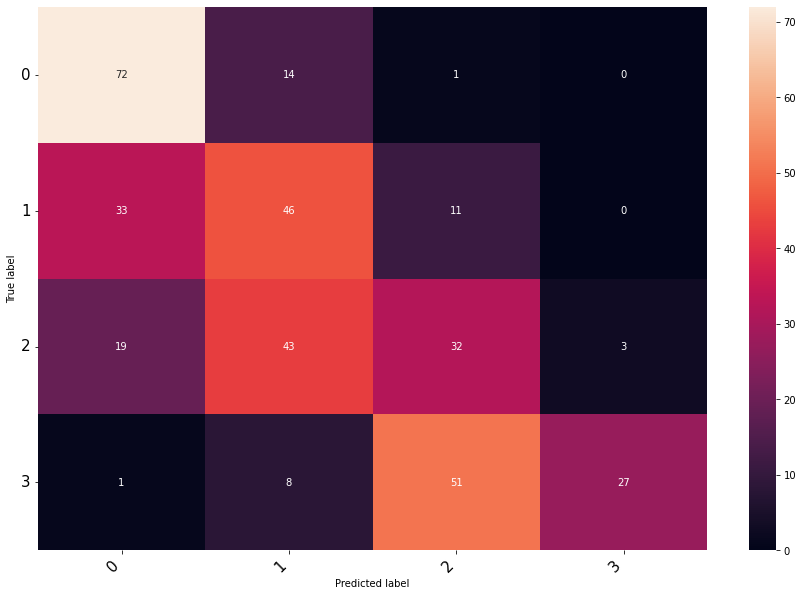

In [70]:
cm.visualize()

In [38]:
cm.class_accuracy

tensor([0.8276, 0.6778, 0.3093, 0.2759])

In [39]:
[mean_squared_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k], squared=False) for k in range(0, cm.size)]

[0.14404848, 0.17285848, 0.27976328, 0.2926671]

In [40]:
[mean_absolute_error(y_true=cm.true_percentiles[cm.labels==k], y_pred=cm.pseudo_perc[cm.labels==k]) for k in range(0, cm.size)]

[0.10137311, 0.13366127, 0.23259754, 0.25074747]

### GAT

In [ ]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    use_edge_weight=[False],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [ ]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            use_edge_weight=use_edge_weight,
            loss_type='mse',
        )

#### Results

In [ ]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

In [ ]:
res_edges = res_edges_gat
res_edges[0]

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

In [ ]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

In [ ]:
pretty([all[k]['dict'] for k in sort_idx])